In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = [redacted] #Sorry. The raw data is private and is restricted for human subjects protection policies.
df = pd.read_csv(path+redacted_results)

In [4]:
#Drop the 2 first ones that aren't actually data.
df = df.drop(0)
df = df.drop(1)

In [5]:
df = df[df['approved']=='1']
df = df[df.Consent=='Yes'] #Only consenters
df = df[(df.screener1_11_TEXT=='k') | (df.screener1_11_TEXT=='K') | (df.screener1_11_TEXT=='"k"') | (df.screener1_11_TEXT=='"K"') | (df.screener1_11_TEXT=='k ')] #Only if they passed the first attention check
df = df[df.screener2=='FoxNews.com,NBC.com'] #Only if they passed the second attention check
df['Duration (in seconds)'] = df['Duration (in seconds)'].astype(int)
df = df[df['Duration (in seconds)']>120]
#df = df[df['Duration (in seconds)']<600]

In [6]:
len(df)

1171

In [7]:
topics = ['china','troops']
pro_antis = ['pro','anti']
targets = ['R','D']
nums = [str(num+1) for num in range(10)]

In [8]:
#Build a list of all the statement column names
statement_cols = []
for t in topics:
  for pa in pro_antis:
    for target in targets:
      for num in nums:
        statement_cols.append(t+'_'+pa+'_'+target+'_'+num)

In [9]:
def group_id_maker(row, group_id):
  group_tag = False
  for i in range(10):
    if pd.notnull(row[group_id+'_'+str(i+1)]):
      group_tag = True
  return group_tag

In [10]:
for t in topics:
  for p in pro_antis:
    for target in targets:
      group_id = t+'_'+p+'_'+target
      df[group_id] = df.apply(lambda x: group_id_maker(x,group_id), axis=1)

In [11]:
def add_response_counts(response_counts, response_totals, response_options):
  for i in range(len(response_totals)):
    try:
      response_totals[i] += response_counts[response_options[i]]
    except KeyError:
      nothing = 'nothing'
  return response_totals

#Overall Ratings

Add in columns to identify the which statements they were shown

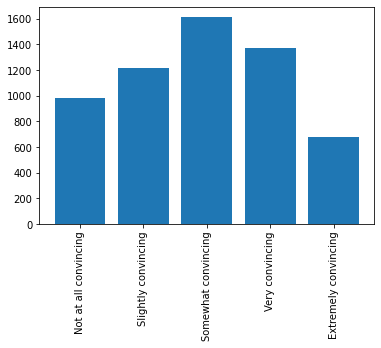

In [12]:
ratings_response_options = ['Not at all convincing', 'Slightly convincing', 'Somewhat convincing', 'Very convincing', 'Extremely convincing']
response_total = [0,0,0,0,0]

for col in statement_cols:
  response_counts = df[col].value_counts()
  response_total = add_response_counts(response_counts, response_total, ratings_response_options)

plt.bar(ratings_response_options, response_total)
plt.xticks(rotation=90)
plt.show()

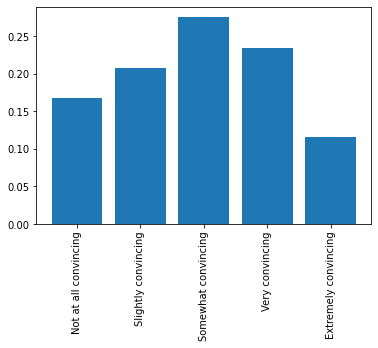

In [13]:
response_fracs = [val/np.sum(response_total) for val in response_total]
plt.bar(ratings_response_options, response_fracs)
plt.xticks(rotation=90)
plt.show()

In [14]:
response_fracs

[0.16715041830288543,
 0.2072733481304422,
 0.2753969609014854,
 0.23459108758750213,
 0.11558818507768483]

Targeted vs Untargeted

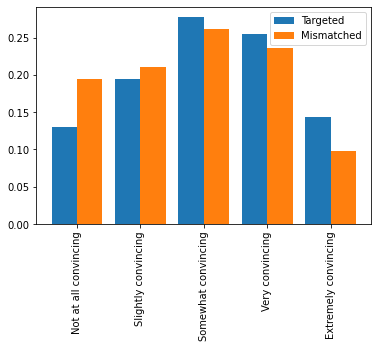

In [15]:
targeted_totals = [0,0,0,0,0]
untargeted_totals = [0,0,0,0,0]
dems_mask = (df['Ideology']=='Closer to liberals') | (df['Ideology']=='Somewhat liberal') | (df['Ideology']=='Very liberal')
reps_mask = (df['Ideology']=='Closer to conservatives') | (df['Ideology']=='Somewhat conservative') | (df['Ideology']=='Very conservative')
targeted_df = df[(dems_mask & (df['PID_target']=='D')) | (reps_mask & (df['PID_target']=='R'))]
untargeted_df = df[(dems_mask & (df['PID_target']=='R')) | (reps_mask & (df['PID_target']=='D'))]
for col in statement_cols:
  targeted_counts = targeted_df[col].value_counts()
  untargeted_counts = untargeted_df[col].value_counts()
  targeted_totals = add_response_counts(targeted_counts, targeted_totals, ratings_response_options)
  untargeted_totals = add_response_counts(untargeted_counts, untargeted_totals, ratings_response_options)

targeted_fracs = [val/np.sum(targeted_totals) for val in targeted_totals]
untargeted_fracs = [val/np.sum(untargeted_totals) for val in untargeted_totals]
#plt.hist(dem_fracs, label='series1', alpha=.8, edgecolor='red') 
#plt.hist(rep_fracs, label='series2', alpha=.8, edgecolor='red')
#plt.legend() 
x = np.arange(5)+1
plt.bar(x-0.2, targeted_fracs, width=0.4, label='Targeted')#, color='b')
plt.bar(x+0.2, untargeted_fracs, width=0.4, label='Mismatched')#, color='r')
plt.xticks(x,ratings_response_options,rotation=90)
plt.legend()
plt.show()

In [16]:
print(targeted_fracs)
print(untargeted_fracs)

[0.13, 0.1944, 0.2776, 0.2548, 0.1432]
[0.19458128078817735, 0.21018062397372742, 0.26108374384236455, 0.23645320197044334, 0.09770114942528736]


In [17]:
print(np.sum(targeted_fracs[2::]))
print(np.sum(untargeted_fracs[2::]))

0.6756
0.5952380952380952


#Overall Shift

In [18]:
temp_df = df

troops_response_options = ['Remove troops','Decrease troops','Maintain troops','Increase troops']

response_counts = temp_df['baseline_troops_1'].value_counts()
pre_troops_1 = add_response_counts(response_counts,[0,0,0,0],troops_response_options)

anti_troops_df = temp_df[(temp_df['troops_anti_R']) | (temp_df['troops_anti_D'])]
response_counts = anti_troops_df['end_troops_1'].value_counts()
anti_post_troops_1 = add_response_counts(response_counts,[0,0,0,0],troops_response_options)

pro_troops_df = temp_df[(temp_df['troops_pro_R']) | (temp_df['troops_pro_D'])]
response_counts = pro_troops_df['end_troops_1'].value_counts()
pro_post_troops_1 = add_response_counts(response_counts,[0,0,0,0],troops_response_options)

print(pre_troops_1)
print(anti_post_troops_1)
print(pro_post_troops_1)

[107, 196, 218, 55]
[42, 108, 124, 27]
[63, 117, 94, 20]


In [19]:
troops_response_options

['Remove troops', 'Decrease troops', 'Maintain troops', 'Increase troops']

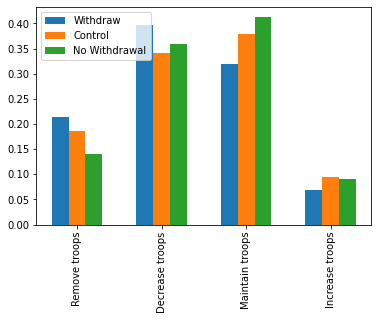

In [20]:
pre_troops_1 = [val/np.sum(pre_troops_1) for val in pre_troops_1]
anti_post_troops_1 = [val/np.sum(anti_post_troops_1) for val in anti_post_troops_1]
pro_post_troops_1 = [val/np.sum(pro_post_troops_1) for val in pro_post_troops_1]

x = np.arange(4)+1
plt.bar(x-0.2,pro_post_troops_1, width=0.2, label='Withdraw')
plt.bar(x,pre_troops_1, width=0.2, label='Control')
plt.bar(x+0.2,anti_post_troops_1, width=0.2, label='No Withdrawal')
plt.xticks(x,troops_response_options,rotation=90)
plt.legend(loc=2)
plt.show()

In [21]:
print(pre_troops_1)
print(anti_post_troops_1)
print(pro_post_troops_1)

[0.1857638888888889, 0.3402777777777778, 0.3784722222222222, 0.0954861111111111]
[0.13953488372093023, 0.3588039867109635, 0.4119601328903654, 0.08970099667774087]
[0.21428571428571427, 0.3979591836734694, 0.3197278911564626, 0.06802721088435375]


Asking Chinese Sanctions Directly

In [22]:
temp_df = df

china_response_options = ['Strongly oppose','Somewhat oppose','Neither favor nor oppose','Somewhat favor','Strongly favor']

response_counts = temp_df['baseline_china_1'].value_counts()
pre_china_1 = add_response_counts(response_counts,[0,0,0,0,0],china_response_options)

anti_china_df = temp_df[(temp_df['china_anti_R']) | (temp_df['china_anti_D'])]
response_counts = anti_china_df['end_china_1'].value_counts()
anti_post_china_1 = add_response_counts(response_counts,[0,0,0,0,0],china_response_options)

pro_china_df = temp_df[(temp_df['china_pro_R']) | (temp_df['china_pro_D'])]
response_counts = pro_china_df['end_china_1'].value_counts()
pro_post_china_1 = add_response_counts(response_counts,[0,0,0,0,0],china_response_options)

print(pre_china_1)
print(anti_post_china_1)
print(pro_post_china_1)

[28, 100, 166, 184, 117]
[29, 87, 77, 68, 27]
[19, 49, 73, 90, 57]


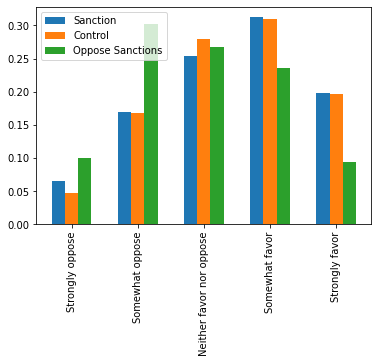

In [23]:
pre_china_1 = [val/np.sum(pre_china_1) for val in pre_china_1]
anti_post_china_1 = [val/np.sum(anti_post_china_1) for val in anti_post_china_1]
pro_post_china_1 = [val/np.sum(pro_post_china_1) for val in pro_post_china_1]

x = np.arange(5)+1
plt.bar(x-0.2, pro_post_china_1, width=0.2, label='Sanction')
plt.bar(x, pre_china_1, width=0.2, label='Control')
plt.bar(x+0.2, anti_post_china_1, width=0.2, label='Oppose Sanctions')
plt.xticks(x,china_response_options,rotation=90)
plt.legend()
plt.show()

In [24]:
print(pre_china_1)
print(anti_post_china_1)
print(pro_post_china_1)

[0.047058823529411764, 0.16806722689075632, 0.27899159663865547, 0.3092436974789916, 0.19663865546218487]
[0.10069444444444445, 0.3020833333333333, 0.2673611111111111, 0.2361111111111111, 0.09375]
[0.06597222222222222, 0.1701388888888889, 0.2534722222222222, 0.3125, 0.19791666666666666]


#Best and Worst Statements

In [25]:
results = []
for col in statement_cols:
  response_counts = df[col].value_counts()
  response_total = [0 for val in ratings_response_options]
  response_total = add_response_counts(response_counts, response_total, ratings_response_options)
  convinced_frac = (response_total[2]+response_total[3]+response_total[4])/np.sum(response_total)
  results.append([convinced_frac,response_total,col])

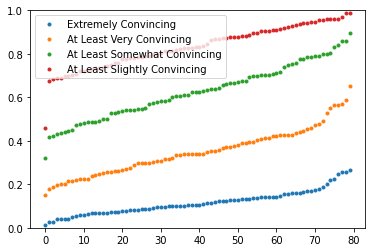

In [26]:
c4 = [(x[1][4])/np.sum(x[1]) for x in results]
c4.sort()
c3 = [(x[1][4]+x[1][3])/np.sum(x[1]) for x in results]
c3.sort()
c2 = [(x[1][4]+x[1][3]+x[1][2])/np.sum(x[1]) for x in results]
c2.sort()
c1 = [(x[1][4]+x[1][3]+x[1][2]+x[1][1])/np.sum(x[1]) for x in results]
c1.sort()
c0 = [(x[1][4]+x[1][3]+x[1][2]+x[1][1]+x[1][0])/np.sum(x[1]) for x in results]

#plt.plot(np.arange(len(c)),0.5*np.ones(len(c)),'--', color='dimgrey')
plt.plot(c4,'.', label='Extremely Convincing')
plt.plot(c3,'.', label='At Least Very Convincing')
plt.plot(c2,'.', label='At Least Somewhat Convincing')
plt.plot(c1,'.', label='At Least Slightly Convincing')
plt.ylim([0,1])
plt.legend()
plt.show()